# ptt 獨立音樂版

## 一. <a href='#資料介紹'>資料介紹</a>

1. 來源
2. 資料介紹
3. 欄位


## 二. <a href='#呈現'>呈現</a>
1. <a href='#1.-Load-Libraries'>Load Libraries</a>
2. <a href='#2.-Load-Data'>Load Data</a>
3. <a href='#3.-Data-Preprocessing'>Data Preprocessing</a>  
    1. Missing Value
    2. Drop PostName
    3. Add New Columns
    3. Columns Preprocess Time
    4. Columns Preprocess Title
4. <a href='#4.-Analyze-Data'>Analyze Data</a>        
4. <a href='#5.-文字雲'>文字雲</a>        




## 資料介紹


### 1.來源
[ptt獨立音樂版](https://www.ptt.cc/bbs/nmsmusic/index.html)的所有資料 

- 獨立音樂的定義：是指有別於主流商業唱片廠牌所製作的音樂。
- 顧名思義，獨立音樂的製作過程獨立自主，從錄音到出版都由音樂家獨力完成。
- 雖然許多獨立音樂家的風格無法清楚界定，因而歸類到不同的音樂類型，但在一般說法上或音樂評論中依舊視為一種音樂類型，包括那些非獨立製作的音樂。


### 2.資料介紹
自己抓ptt獨立音樂版的資料：2016/4/5～2019/11/23

### 3.欄位

Shape：(2517, 6)


欄位|描述
:---:|:---:
Title|標題名稱
Time|發文時間
PostId|發文作者的帳號跟名稱
Content|內文
ReplyId|回覆者的id
Reply|回覆者


<a href='#ptt-獨立音樂版'>Back To Top</a>

---

## 呈現

## 1. Load Libraries

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import jieba
import jieba.analyse
from wordcloud import WordCloud

%matplotlib inline
pd.set_option('display.float_format',lambda x : '%.2f' % x)
# pd.set_option('display.max_rows', 1000)
# pd.set_option('display.max_columns', 30)

import warnings
warnings.filterwarnings('ignore')

sns.set()

<a href='#ptt-獨立音樂版'>Back To Top</a>

---

## 2. Load Data

In [7]:
df = pd.read_csv('../input/nmsmusic_all.csv')
df = df.rename(columns={'標題':'Title', '時間': 'Time', '作者':'PostId', '內文': 'Content', '留言作者':'ReplyId', '留言':'Reply'})
df = df.drop(['Unnamed: 0'], axis=1)

### 資料筆數：(2517, 6)

In [8]:
df.shape

(2517, 6)

In [9]:
df.head(4)

,Title,Time,PostId,Content,ReplyId,Reply
0,[新板成立] nmsmusic板,Tue Apr 5 19:53:04 2016,skydreaming ((‵▽′)Ψ..咦？),\n\n 茲因 yanagi5566 於 Buzz_Theater 申請...,[],[]
1,[閒聊] 恭喜開板,Tue Apr 5 19:53:17 2016,swattw (Swat-未來模式),\nAs Title\n\n--\n ◢◢ξ ...,['moon70552'],[': 推 跟我一樣來洗文DER']
2,[閒聊] 恭喜開板,Tue Apr 5 20:16:28 2016,Firstshadow (MentalUTN),\n恭喜開板 ⊙_⊙\n\n\n\n--\nSent from my iPhone 8\n...,['Yanagi5566'],[': 嘻嘻']
3,[賀開]板恭喜開板,Tue Apr 5 20:31:07 2016,moon70552 (丟啦),\n【賀開板】\n【賀開板】\n【賀開板】\n【賀開板】\n【賀開板】\n【賀開板】\n 【...,['Yanagi5566'],"["": o'_'o""]"


<a href='#ptt-獨立音樂版'>Back To Top</a>

---

## 3. Data Preprocessing
1. Missing Value
2. Drop PostName
3. Add New Columns
3. Columns Preprocess Time
4. Columns Preprocess Title

### 3.1 Missing Value

In [10]:
def na_check(df):
    missing = pd.DataFrame(df.isnull().sum(), columns=['missing'])
    missing = missing.sort_values(ascending=False, by=['missing'])
    missing = missing[missing['missing']>0]
    if len(missing)==0:
        print('No Missing Value !')
    else:
        display(missing)
na_check(df)

No Missing Value !


### 3.2 Drop PostName
只取出發文者的id，捨棄發文者的名稱

In [11]:
df['PostId'] = df['PostId'].apply(lambda x:x.split(' ')[0])
df['PostId'][0:5]

0    skydreaming
1         swattw
2    Firstshadow
3      moon70552
4         rehtra
Name: PostId, dtype: object

### 3.3 Add New Columns
- Reply_Count：留言次數
- Title_Content_Reply：文章標題+內容+回覆

In [12]:
df['Reply_Count'] = df['Reply'].apply(lambda x:len(x.split(',')) if len(x)>2 else 0)

In [13]:
df['Title_Content_Reply'] = df['Title'] + df['Content'] + df['Reply']

### 3.4 Columns Preprocess Time
### 把時間拆開
1. 年
2. 月
3. 日
4. 小時
5. 星期
    
### 轉換英文 -> 數字
1. 月份 (Jan -> 1)
2. 星期(Tue -> 2)

In [14]:
df.insert(loc=2, column='Year', value=df['Time'].apply(lambda x:x[-4:]))
df.insert(loc=3, column='Month', value=df['Time'].apply(lambda x:x.split(' ')[1]))
df.insert(loc=4, column='Day', value=df['Time'].apply(lambda x:x.split(' ')[-3]))
df.insert(loc=5, column='Hour', value=df['Time'].apply(lambda x:x.split(':')[0][-2:]))
df.insert(loc=6, column='Weekday', value=df['Time'].apply(lambda x:x.split(' ')[0]))

### 可以看出有些資料轉換錯誤
1. 年份應該只有2016-2019
2. 日應該只有31天

In [15]:
print('Year Unique Num : ', len(df['Year'].unique()), '  -------  ' ,df['Year'].unique())
print('Month Unique Num: ',len(df['Month'].unique()), '  -------  ' , df['Month'].unique())
print('Day Unique Num: ', len(df['Day'].unique()), '  -------  '  , df['Day'].unique())
print('Hour Unique Num: ', len(df['Hour'].unique()), '  -------  ' ,  df['Hour'].unique())
print('Weekday Unique Num: ', len(df['Weekday'].unique()), '  -------  ' ,  df['Weekday'].unique())

Year Unique Num :  7   -------   ['2016' '2017' '2018' '2:39' '9 20' '2019' ' 201']
Month Unique Num:  12   -------   ['Apr' 'May' 'Jun' 'Jul' 'Aug' 'Sep' 'Oct' 'Nov' 'Dec' 'Jan' 'Feb' 'Mar']
Day Unique Num:  32   -------   ['5' '6' '7' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '20' '21'
 '22' '23' '25' '26' '27' '28' '29' '30' '1' '2' '3' '4' '24' '9' '31' '8'
 '']
Hour Unique Num:  24   -------   ['19' '20' '22' '01' '15' '13' '17' '18' '23' '10' '16' '00' '14' '04'
 '03' '12' '09' '02' '21' '06' '11' '07' '08' '05']
Weekday Unique Num:  7   -------   ['Tue' 'Wed' 'Thu' 'Sun' 'Mon' 'Fri' 'Sat']


In [16]:
show_unique = ['Year', 'Month', 'Day', 'Hour', 'Weekday']

### 這邊找出轉換錯誤的然後更正

In [17]:
df.loc[1010, 'Year']= '2018'
df.loc[1526, 'Year']= '2018'
df.loc[2067, 'Year']= '2019'
df.loc[1010, 'Day']= '4'

### 更正後的數據就都對了

In [18]:
for i in show_unique:
    u = len(df[i].unique())
    print(i, 'Have ', u, ' Unique  : ', df[i].unique())
    print('\n')

Year Have  4  Unique  :  ['2016' '2017' '2018' '2019']


Month Have  12  Unique  :  ['Apr' 'May' 'Jun' 'Jul' 'Aug' 'Sep' 'Oct' 'Nov' 'Dec' 'Jan' 'Feb' 'Mar']


Day Have  31  Unique  :  ['5' '6' '7' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '20' '21'
 '22' '23' '25' '26' '27' '28' '29' '30' '1' '2' '3' '4' '24' '9' '31' '8']


Hour Have  24  Unique  :  ['19' '20' '22' '01' '15' '13' '17' '18' '23' '10' '16' '00' '14' '04'
 '03' '12' '09' '02' '21' '06' '11' '07' '08' '05']


Weekday Have  7  Unique  :  ['Tue' 'Wed' 'Thu' 'Sun' 'Mon' 'Fri' 'Sat']




### 轉換英文成數字

In [19]:
month_mapping = {'Apr':4, 'May':5, 'Jun':6, 'Jul':7, 'Aug':8, 'Sep':9, 'Oct':10, 'Nov':11, 'Dec':12,
                           'Jan':1, 'Feb':2, 'Mar':3}
weekday_mapping = {'Tue':2, 'Wed':3, 'Thu':4, 'Sun':7, 'Mon':1, 'Fri':5, 'Sat':6}

df['Month'] = df['Month'].map(month_mapping)
df['Weekday'] = df['Weekday'].map(weekday_mapping)

### 年份+月份

In [20]:
df['Month'] = df['Month'].apply(lambda x:'0' + str(x))

In [21]:
df['Month'] = df['Month'].replace('010', '10')
df['Month'] = df['Month'].replace('011', '11')
df['Month'] = df['Month'].replace('012', '12')

In [22]:
df.insert(loc=7, column='Year_Month', value=df['Year'] + '-'+ df['Month'])

In [23]:
df.head(2)

,Title,Time,Year,Month,Day,Hour,Weekday,Year_Month,PostId,Content,ReplyId,Reply,Reply_Count,Title_Content_Reply
0,[新板成立] nmsmusic板,Tue Apr 5 19:53:04 2016,2016,04,5,19,2,2016-04,skydreaming,\n\n 茲因 yanagi5566 於 Buzz_Theater 申請...,[],[],0,[新板成立] nmsmusic板\n\n 茲因 yanagi5566 於...
1,[閒聊] 恭喜開板,Tue Apr 5 19:53:17 2016,2016,04,5,19,2,2016-04,swattw,\nAs Title\n\n--\n ◢◢ξ ...,['moon70552'],[': 推 跟我一樣來洗文DER'],1,[閒聊] 恭喜開板\nAs Title\n\n--\n ◢◢ξ ...


### 3.5 Columns Preprocess Title

- 找出所有的分類，並針對有興趣的分類做標註

欄位|分類
:---:|:---:
Info|情報
Ques|問題
Share|分享
Thoughts|心得
Chat|閒聊
Recommend|推薦
Transaction|交易
Sale|售


In [24]:
df['Info'] = df['Title'].apply(lambda x:1 if '情報' in x else 0)
df['Ques'] = df['Title'].apply(lambda x:1 if '問題' in x else 0)
df['Share'] = df['Title'].apply(lambda x:1 if '分享' in x else 0)
df['Thoughts'] = df['Title'].apply(lambda x:1 if '心得' in x else 0)
df['Chat'] = df['Title'].apply(lambda x:1 if '閒聊' in x else 0)
df['Recommend'] = df['Title'].apply(lambda x:1 if '推薦' in x else 0)
df['Transaction'] = df['Title'].apply(lambda x:1 if '交易' in x else 0)
df['Sale'] = df['Title'].apply(lambda x:1 if '售' in x else 0)
df['SongList'] = df['Title'].apply(lambda x:1 if '歌單' in x else 0)

df['Sum_Category'] = df[['Info', 'Ques', 'Share', 'Thoughts', 'Chat', 'Recommend', 'Transaction', 'Sale', 'SongList']].sum(axis=1)


In [25]:
df.head(2)

,Title,Time,Year,Month,Day,Hour,Weekday,Year_Month,PostId,Content,...,Info,Ques,Share,Thoughts,Chat,Recommend,Transaction,Sale,SongList,Sum_Category
0,[新板成立] nmsmusic板,Tue Apr 5 19:53:04 2016,2016,04,5,19,2,2016-04,skydreaming,\n\n 茲因 yanagi5566 於 Buzz_Theater 申請...,...,0,0,0,0,0,0,0,0,0,0
1,[閒聊] 恭喜開板,Tue Apr 5 19:53:17 2016,2016,04,5,19,2,2016-04,swattw,\nAs Title\n\n--\n ◢◢ξ ...,...,0,0,0,0,1,0,0,0,0,1


In [26]:
count_ = len(df[df['Sum_Category']>0]) 
percent_ = round(100 * (count_/df.shape[0] ))
print('有標註的標題分類有：', count_ ,'筆資料')
print('- - '*10)
print('有標註的分類佔全部資料的 ', percent_, '%')

有標註的標題分類有： 1961 筆資料
- - - - - - - - - - - - - - - - - - - - 
有標註的分類佔全部資料的  78 %


<a href='#ptt-獨立音樂版'>Back To Top</a>

---

## 4. Analyze Data

### 4.1 年份的發文次數
可以看出最高的年份為2018，因為2019還有一個多月，所以發文次數還是有機會比2018高

In [27]:
gb_year = df.groupby('Year').count()[['Title']]
year_post = pd.DataFrame({'Year':gb_year.index, 'Count':gb_year['Title'].values})
year_post

,Year,Count
0,2016,268
1,2017,488
2,2018,956
3,2019,805


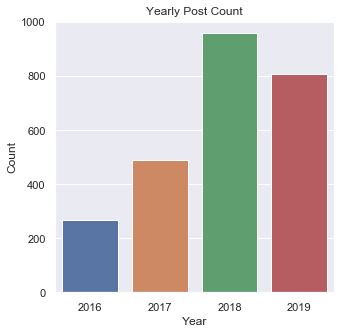

In [28]:
plt.figure(figsize=(5,5))
sns.barplot(x=year_post.Year, y=year_post.Count)
plt.title('Yearly Post Count')
plt.show()

### 4.2 月份的發文趨勢圖
- 可以看出2018-10月的發文是最多的
- 有些月份的發文會特別多有些會特別少
- 原因是有些月份會有音樂祭，所以發文次數會比較多

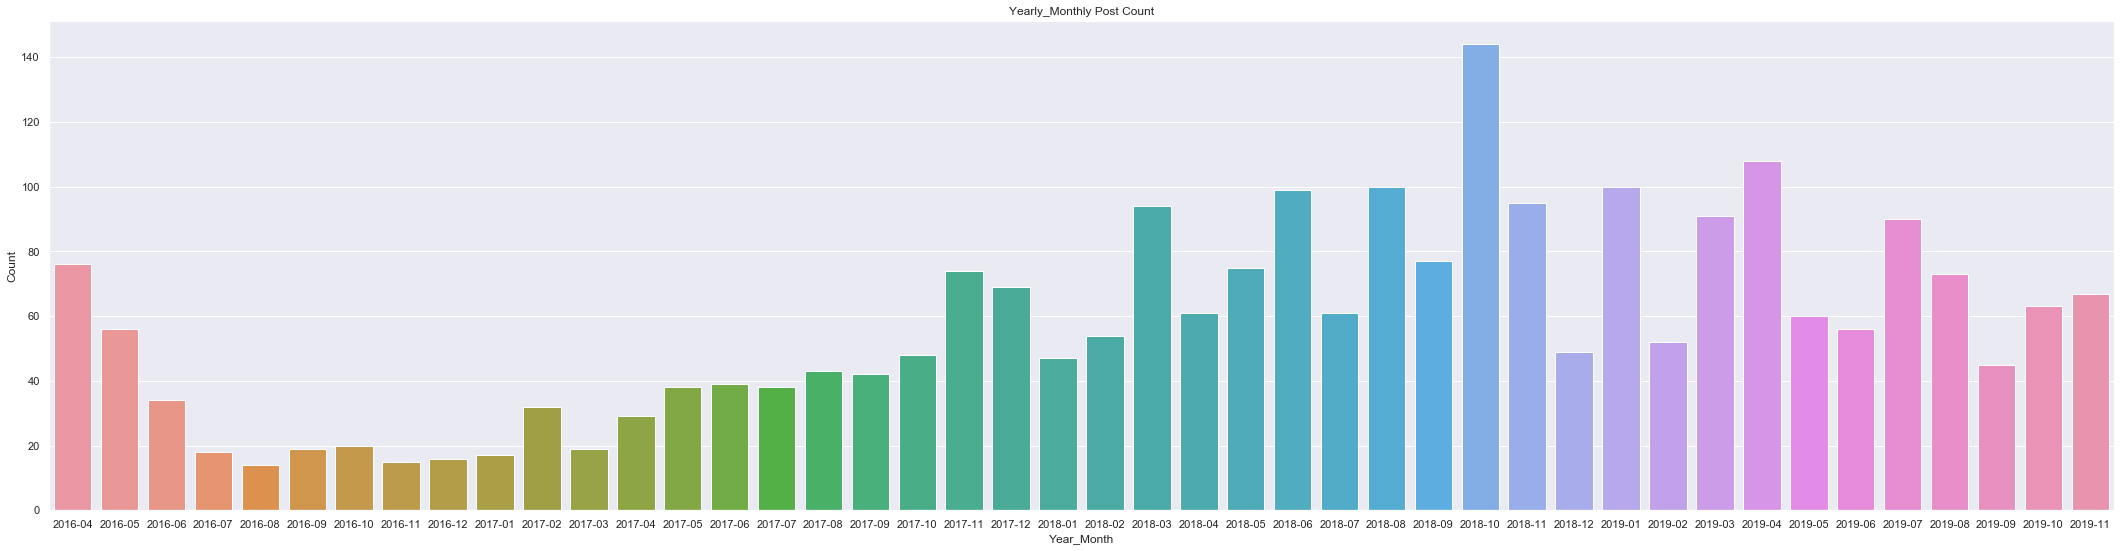

In [29]:
gb_y_m = df.groupby('Year_Month').count()[['Title']]
year_month_post = pd.DataFrame({'Year_Month':gb_y_m.index, 'Count':gb_y_m['Title'].values})
plt.figure(figsize=(37,9))
sns.barplot(x=year_month_post.Year_Month, y=year_month_post.Count)
plt.title('Yearly_Monthly Post Count')
plt.show()

### 4.3 發文時間

- 可以看出發文時間大多都集中在晚上11, 12點

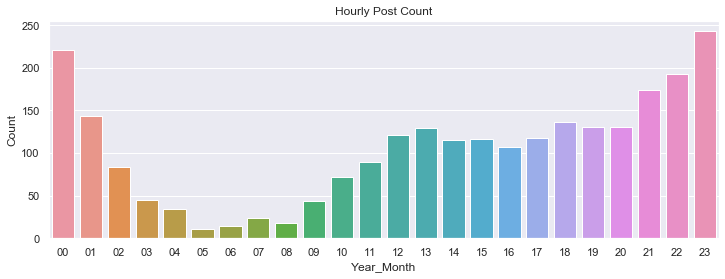

In [30]:
gb_h = df.groupby('Hour').count()[['Title']]
hour_post = pd.DataFrame({'Year_Month':gb_h.index, 'Count':gb_h['Title'].values})
plt.figure(figsize=(12,4))
sns.barplot(x=hour_post.Year_Month, y=hour_post.Count)
plt.title('Hourly Post Count')
plt.show()

### 4.4 回應比例

In [31]:
df['Reply_Count_YesNo'] = df['Reply_Count'].apply(lambda x:1 if x>0 else 0)

In [32]:
Reply_Count = ['Yes', 'No']
Reply_Count_YesNo_df = pd.DataFrame({'Percent':df['Reply_Count_YesNo'].value_counts().values}, index=Reply_Count)

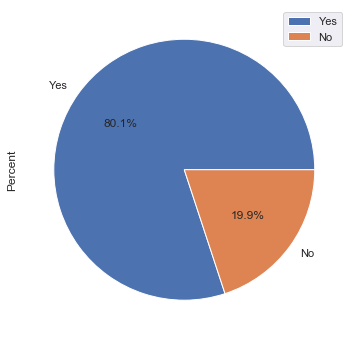

In [33]:
Reply_Count_YesNo_df.plot(kind='pie', y='Percent', figsize=(10,6), autopct='%1.1f%%')
plt.rcParams.update({'font.size': 22})
plt.show()

## 5. 文字雲

## 5.1 全部資料
### 結巴
- 這邊我使用的是結巴做斷詞
- 我有加入我自己建的樂團名稱的字典：banddict.txt
- 還有加入一些停用詞的字典：stopwords.txt

In [34]:
def stopwordslist(filepath):  
    stopwords = [line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()]  
    return stopwords  

def seg_sentence(sentence):  
    jieba.load_userdict("../input/wordlist/banddict.txt")
    sentence_seged = jieba.cut(sentence)  
    stopwords = stopwordslist('../input/wordlist/stopwords.txt') 
    outstr = ''  
    for word in sentence_seged:  
        if word not in stopwords:  
            if word != '\t':  
                outstr += word  
                outstr += ' ' 
    return outstr  

def not_load_dict(sentence):
    sentence_seged = jieba.cut(sentence)  
    outstr = ''  
    for word in sentence_seged:  
        outstr += word  
        outstr += ' ' 
    return outstr  

def get_list(df):
    index_ = list(df.index)
    word_list =''
    for i in index_:
        word_list += df['Title_Content_Reply'][i]
    
    return word_list

### 沒有放進自己建的樂團詞跟stopword
有意義的詞就會比較少，就比較無法呈現我們想看的結果

In [35]:
word_list = get_list(df)
test = not_load_dict(word_list)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/yd/hbm8w0m53sbdghwdjn63dyyw0000gn/T/jieba.cache
Loading model cost 0.674 seconds.
Prefix dict has been built succesfully.


In [36]:
font = '/Library/Fonts/Kaiu.ttf'
sns.set(rc={'figure.figsize':(10,6)})
my_wordcloud = WordCloud(font_path=font, background_color="white", scale=4, 
                         max_words = 100,max_font_size = 60,random_state=20).generate(test)
my_wordcloud.to_file('../output/not_load_dict.jpg')

<img src='../output/not_load_dict.jpg' style='zoom:50%'>

### 放進自己建的
- banddict：樂團名
- stopwords：刪掉一些不需要的詞

In [37]:
word_list = get_list(df)
test = seg_sentence(word_list)

In [38]:
font = '/Library/Fonts/Kaiu.ttf'
sns.set(rc={'figure.figsize':(10,6)})
my_wordcloud = WordCloud(font_path=font, background_color="white", scale=4, 
                         max_words = 100,max_font_size = 60,random_state=20).generate(test)
my_wordcloud.to_file('../output/load_dict.jpg')
# plt.imshow(my_wordcloud)
# plt.axis("off")
# plt.show()

<img src='../output/load_dict.jpg' style='zoom:50%'>

### 5.2 心得+分享的標題

In [39]:
df['Thoughts_Share'] = df['Thoughts'] + df['Share']
Thoughts_Share = df[df['Thoughts_Share']>=1]

In [40]:
word_list = get_list(Thoughts_Share)
test = seg_sentence(word_list)

In [41]:
font = '/Library/Fonts/Kaiu.ttf'
sns.set(rc={'figure.figsize':(10,6)})
my_wordcloud = WordCloud(font_path=font, background_color="white", scale=4, 
                         max_words = 100,max_font_size = 60,random_state=20).generate(test)
my_wordcloud.to_file('../output/Thoughts_Share.jpg')

<img src='../output/Thoughts_Share.jpg' style='zoom:50%'>

### 5.3 2018-10
#### 把一些關鍵字放進去看，是哪些因素讓2018年10月的發文次數較多
1. 放一些音樂祭的名稱：遊牧, 愛愛, 金音, 貴人, 巨獸
2. 跟一些當月有辦專場的樂團：美秀, 茄子, joins (Deca joins)

In [42]:
pd.set_option('display.float_format',lambda x : '%d' % x)

In [43]:
df_201810 = df[df['Year_Month']=='2018-10']
col = ['Nomad_Festival', 'Love', 'Golden', 'LUCFest', 'Bisup', 'Egg', 'Deca', 'BeastieRock']
word_ = ['遊牧', '愛愛', '金音', '貴人', '美秀', '茄子', 'joins', '巨獸']
percent_list = []

for col, word in zip(col, word_):
    df_201810[col] = df_201810['Title_Content_Reply'].apply(lambda x:1 if word in x else 0)
    percent = round(100*(df_201810[col].sum()/len(df_201810)), 1)
    percent_list.append(percent)
    
df_percentage_201810 = pd.DataFrame({'Word':word_, 'Percentage':percent_list})
df_percentage_201810 = df_percentage_201810.append({'Word': 'All', 'Percentage':df_percentage_201810['Percentage'].sum()}, ignore_index=True)


### 標題+內容+回覆   比例
- 從這個表格可以看出 '遊牧', '愛愛', '金音', '貴人', '美秀', '茄子', 'joins', '巨獸' ，這幾個主題就佔了資料的 78 %


- 最大的比例是遊牧音樂祭(10/13-10/14) 20%，演出陣容（茄子蛋、韋禮安、滅火器、草東沒有派對、麋先生、法蘭黛、Hello Nico、董事長、告五人、I Mean Us、先知瑪莉等），都是獨立音樂圈裡人氣很高的樂團


- 再來是金音獎(10/27) 16%，是台灣繼金曲獎之後的另一項特殊性質的音樂獎，與金曲獎流行音樂類似，但其主要為獨立音樂領域，演出陣容（Vast & Hazy、南瓜妮歌迷俱樂部、TRASH、茄子蛋、老王樂隊、好樂團、三十萬年老虎鉗等）


- 茄子蛋(9/28、9/30)、Deca Joins(10/6售票、11/15演出)、美秀集團（10/5、10/19、10/26）則是當時有舉辦或即將舉辦專場的樂團


- 貴人音樂祭(11/30)跟巨獸搖滾(10/5)也都是10月附近的音樂祭

In [44]:
df_percentage_201810.sort_values(by='Percentage')

,Word,Percentage
7,巨獸,1
3,貴人,2
1,愛愛,6
4,美秀,8
6,joins,10
5,茄子,13
2,金音,16
0,遊牧,20
8,All,78


In [45]:
word_list201810 = get_list(df_201810)
test = seg_sentence(word_list201810)

In [46]:
font = '/Library/Fonts/Kaiu.ttf'
my_wordcloud = WordCloud(font_path=font, background_color="white", scale=4, 
                         max_words = 100,max_font_size = 60,random_state=20).generate(test)
my_wordcloud.to_file('../output/result_201810.jpg')

### 文字雲
- 可以看得出來這有些詞跟上面做的有重複，但有些詞是我上面沒有放進去的

#### 巨獸搖滾
- 巨獸搖滾佔的比重很大，原因是因為當時的巨獸搖滾面臨停辦的危機，因為創辦人的團隊撕破臉

- 也因為一些經費上的不足而有考慮要停辦，經費不足的原因為玩獨立樂團的人普遍都很難賺到錢，很多個音樂祭都是借錢才辦得出來的或是要去向廠商找贊助

- 那在上面為什麼巨獸只有佔2018年10月的1%呢？因為討論巨獸的言論都集中在一篇討論

- 上面的分法是如果標題+內容+回覆之中有出現過的就算1次，而文字雲的分法是按照詞出現次數來做的，所以出現的次數越多字就會越大，因此這就是巨獸在上面出現的只有1%，在文字雲卻出現很大字的原因

- [巨獸搖滾新聞](https://m.ltn.com.tw/news/life/breakingnews/2570131)

#### 草東沒有派對
- 草東算是獨立音樂圈裡很紅的團，甚至沒有在聽獨立音樂的人也多少都聽過草東

- 在文字雲中會出現很大的字，我的判斷為他們在2017年得了金曲獎最佳新人後，團員陸續去當兵以及去美國巡迴，所以遊牧音樂季應該算是這陣子唯一看得到他們的場合，所以大家才會在這個時候的討論很多

#### 告五人
- 告五人很早就創立了，但經過這幾年時間的過去，團員都換了一輪

- 而我的判斷為他們在2018/10/30，正式發行披星戴月的想你的這首單曲，這首是他們最有名的歌曲，雖然之前其實就已經有在放youtube跟streetvoice上了，很多人也都聽過了，而且他們也有演出遊牧音樂祭，所以討論的次數也會比較多


#### 拍謝少年
- 金音獎的最佳搖滾專輯得獎！

- 嘻啤派對(10/20)、綠空鐵道音樂會(10/27)

- 我的判斷為拍謝少年在10月內有兩場表演以及得了最佳搖滾專輯奬，所以討論也會比較多

<img src='../output/result_201810.jpg' style='zoom:50%'>

In [48]:
keywords = jieba.analyse.extract_tags(test, topK=20, withWeight=True)
keywords

[('巨獸', 0.07230363154592997),
 ('拍謝少年', 0.04508344084628575),
 ('告五人', 0.04508344084628575),
 ('2018', 0.039979655090102456),
 ('茄子蛋', 0.03912902413073858),
 ('12', 0.03657713125264693),
 ('音樂節', 0.033174607415191404),
 ('30', 0.031473345496463634),
 ('金音', 0.030072646583520705),
 ('草東', 0.028070821659008108),
 ('游牧', 0.0264440498183293),
 ('高雄場', 0.025518928780916463),
 ('專場', 0.025518928780916463),
 ('巨獸搖滾', 0.023817666862188697),
 ('joins', 0.023817666862188697),
 ('滅火器', 0.022967035902824815),
 ('20', 0.022116404943460934),
 ('2375EP', 0.022116404943460934),
 ('售出', 0.021898171355095346),
 ('26', 0.02041514302473317)]

### 9月到現在的討論趨勢

In [49]:
df_2019 = df[df['Year']=='2019']
df_2019['Month'] = df_2019['Month'].astype(int)
df_2019_9 = df_2019[df_2019['Month']>=9]

In [50]:
word_list = get_list(df_2019_9)
test = seg_sentence(word_list)

In [51]:
font = '/Library/Fonts/Kaiu.ttf'
sns.set(rc={'figure.figsize':(10,6)})
my_wordcloud = WordCloud(font_path=font, background_color="white", scale=4, 
                         max_words = 100,max_font_size = 60,random_state=20).generate(test)
my_wordcloud.to_file('../output/df_2019_9.jpg')

<img src='../output/df_2019_9.jpg' style='zoom:50%'>

<a href='#ptt-獨立音樂版'>Back To Top</a>